In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.shape

(25660, 12)

In [4]:
test.shape

(6416, 11)

In [5]:
X = train

### Transformation Log to Normal distribution

In [6]:
y = X['price']
X = pd.concat([X.loc[:, X.columns != 'price'], test])

In [7]:
numeric_features = ['surface_total', 'rooms', 'bedrooms', 'bathrooms']
cat_features = ['pais','provincia_departamento', 'ciudad']
features = cat_features + numeric_features

In [8]:
from scipy.stats import skew


skewed_feats = X[numeric_features].apply(lambda x: skew(x))
#skewed_feats = skewed_feats[skewed_feats > 0.75]
#skewed_feats
skewed_feats = skewed_feats.index

X[skewed_feats] = np.log1p(X[skewed_feats])
y = np.log1p(y)

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cat_features= ['pais', 'ciudad', 'provincia_departamento']

X['pais'] = le.fit_transform(X['pais'])
X['ciudad'] = le.fit_transform(X['ciudad'])
X['provincia_departamento'] = le.fit_transform(X['provincia_departamento'])


In [10]:
final_features = pd.get_dummies(X[cat_features + numeric_features]).reset_index(drop=True)

In [11]:
final_features

,pais,ciudad,provincia_departamento,surface_total,rooms,bedrooms,bathrooms
0,0,235,9,3.637586,1.098612,0.693147,0.693147
1,0,148,9,5.707110,1.945910,1.609438,1.609438
2,1,20,1,4.564348,1.386294,1.386294,1.386294
3,1,35,35,4.110874,1.386294,1.386294,0.693147
4,0,16,9,3.828641,1.386294,1.098612,0.693147
...,...,...,...,...,...,...,...
32071,0,59,15,4.290459,1.386294,0.693147,0.693147
32072,0,173,9,3.688879,0.693147,0.693147,0.693147
32073,0,31,9,4.465908,1.609438,1.098612,0.693147
32074,1,20,1,4.343805,1.386294,1.386294,1.098612


In [30]:
test = final_features[len(y):]
X_train = final_features[:len(y)]

### Machine Learning

#### Models

Regularized linear regression

In [13]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNetCV, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

In [14]:
m_ridge = make_pipeline(RobustScaler(),Ridge())

In [15]:
alphas_ridge = [0.05,0.1,0.3,1,3,5,10]

cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas_ridge]

Text(0, 0.5, 'rmse')

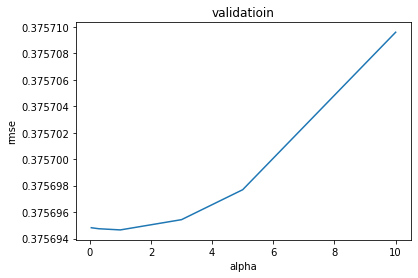

In [16]:
cv_ridge = pd.Series(cv_ridge, index=alphas_ridge)
cv_ridge.plot(title = 'validatioin')
plt.xlabel('alpha')
plt.ylabel('rmse')

In [17]:
from sklearn.model_selection import KFold

kfolds = KFold(n_splits=10,shuffle=True)

def cv_rmse(model, X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)

#### Lasso

In [18]:
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7,alphas=[5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]))

In [19]:
score = cv_rmse(lasso, X_train)
print('Lasso Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

Lasso Score 0.3756 (0.0062)


#### Ridge

In [20]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=[14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]))

score = cv_rmse(ridge, X_train)
print('Ridge Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

Ridge Score 0.3757 (0.0073)


### ElasticNet

In [21]:
elastic = make_pipeline(RobustScaler(), ElasticNetCV(alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007], 
                                                     l1_ratio=[0.8, 0.85, 0.9, 0.95, 0.99, 1]))

score = cv_rmse(elastic, X_train)
print('Elastic Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

Elastic Score 0.3756 (0.0078)


#### SVR

In [22]:
from sklearn.svm import SVR

svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))

score = cv_rmse(svr, X_train)
print('SVR Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

SVR Score 0.3582 (0.0075)


### GradientBoostingRegressor

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, loss='huber', random_state=42)

score = cv_rmse(gbr, X_train)
print('GBR Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

GBR Score 0.2556 (0.0070)


### LightGBM

In [24]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor(objective='regression', learning_rate=0.08, n_estimators=4000, num_leaves=32,max_depth=7, reg_alpha=0.0001)

score = cv_rmse(lgb, X_train)
print('LGBM Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

LGBM Score 0.2591 (0.0085)


### Catboost

In [25]:
from catboost import CatBoostRegressor


catboost = CatBoostRegressor(learning_rate=0.05, n_estimators=10000, max_depth=5, verbose=False, random_seed=42,
                            max_leaves=32, min_data_in_leaf=1)

score = cv_rmse(catboost, X_train)
print('Catboost Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

Catboost Score 0.2555 (0.0125)


### XGboost

In [26]:
from xgboost import XGBRegressor
xgb = XGBRegressor(learning_rate=0.08, n_estimators=3000, max_depth=7, reg_alpha=0.0001, objective='reg:squarederror', max_leaves=10)
score = cv_rmse(xgb, X_train)
print('XGB Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

XGB Score 0.2700 (0.0107)


#### RandomForest

In [27]:
from sklearn.ensemble import RandomForestRegressor

rnd = RandomForestRegressor(n_estimators=4000, criterion='mse', max_depth=7, random_state=42, n_jobs=4, min_samples_leaf=10)

score = cv_rmse(rnd, X_train)
print('Random_forest Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

Random_forest Score 0.3107 (0.0056)


### Stack Pred

In [28]:
from sklearn.ensemble import StackingRegressor

est = [('lasso', lasso), ('ridge', ridge), ('elastic', elastic), ('rnadomforest',rnd), ('gradient', gbr),('xgboost', xgb), ('lightgmb',lgb), ('cat', catboost)]
stack_gen = StackingRegressor(estimators=est,
                                final_estimator=gbr,
                                n_jobs=4)

### Fit

In [29]:
stack_gen.fit(X_train, y)
lasso.fit(X_train,y)
ridge.fit(X_train,y)
elastic.fit(X_train,y)
svr.fit(X_train,y)
gbr.fit(X_train,y)
xgb.fit(X_train,y)
lgb.fit(X_train,y)
rnd.fit(X_train,y)
catboost.fit(X_train, y)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


## Test Prediction

In [55]:
def blend_models_prediction(X):
      return ((0.4 * gbr.predict(X)) + \
            (0.3 * xgb.predict(X)) + \
            (0.3 * catboost.predict(X)) + \
            (0 * stack_gen.predict(X)))

In [32]:
from sklearn.metrics import mean_squared_error
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [56]:
score = rmsle(y,blend_models_prediction(X_train))
print('RMSLE Score on train data{}'.format(score))

RMSLE Score on train data0.1969327668225259


In [34]:
score = rmsle(y,(gbr.predict(X_train) * 0.6 + stack_gen.predict(X_train) * 0.4))
print('RMSLE Score on train data{}'.format(score))

RMSLE Score on train data0.21636589193523198


In [34]:
score = rmsle(y,(gbr.predict(X_train) * 0.7 + stack_gen.predict(X_train) * 0.5))
print('RMSLE Score on train data{}'.format(score))

RMSLE Score on train data2.35025377232455


In [57]:
prediction = blend_models_prediction(test)

In [58]:
submission = pd.DataFrame({'id': test.index,
                           'price':np.expm1(prediction)})

In [59]:
submission.to_csv('final_blend.csv', index=False)

## CURRENT TOP 0.2493RUB SSJ GOD

Fix outliers...
